In [6]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime as dt

In [5]:
help(yf.download)

Help on function download in module yfinance.multi:

download(tickers, start=None, end=None, actions=False, threads=True, ignore_tz=None, group_by='column', auto_adjust=None, back_adjust=False, repair=False, keepna=False, progress=True, period='max', interval='1d', prepost=False, proxy=<object object at 0x000001C61FF9C0F0>, rounding=False, timeout=10, session=None, multi_level_index=True) -> Optional[pandas.core.frame.DataFrame]
    Download yahoo tickers
    :Parameters:
        tickers : str, list
            List of tickers to download
        period : str
            Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
            Either Use period parameter or use start and end
        interval : str
            Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
            Intraday data cannot extend last 60 days
        start: str
            Download start date string (YYYY-MM-DD) or _datetime, inclusive.
            Default is 99 years ago
            E.g. for sta

In [15]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'NVDA', 'NFLX']
end_date = dt.datetime(2025, 1, 1); start_date = end_date - dt.timedelta(days=2*365)
stock = yf.download(tickers, start=start_date, end=end_date)
stock.head()

[*********************100%***********************]  5 of 5 completed


Price            Close                                                \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA   
Date                                                                   
2023-01-03  123.470604  88.695953  234.808975  294.950012  14.303279   
2023-01-04  124.744125  87.660896  224.537674  309.410004  14.736923   
2023-01-05  123.421249  85.789848  217.882874  309.700012  14.253322   
2023-01-06  127.962425  86.924408  220.450668  315.549988  14.846836   
2023-01-09  128.485641  87.601181  222.597061  315.170013  15.615206   

Price             High                                                ...  \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA  ...   
Date                                                                  ...   
2023-01-03  129.226044  90.616770  240.856103  298.390015  14.983722  ...   
2023-01-04  127.014716  90.218667  228.232587  311.140015  14.840838  ...   
2023-01-05  126.136083  87.153332  223.018529  314.179993  14.552077  ...   
2023-01-06  128.623856  87.272749  221.264141  316.769989  14.997712  ...   
2023-01-09  131.703962  89.621528  226.635024  321.700012  16.042855  ...   

Price             Open                                                \
Ticker            AAPL      GOOGL        MSFT        NFLX       NVDA   
Date                                                                   
2023-01-03  128.613978  89.163711  238.239276  298.059998  14.838840   
2023-01-04  125.267347  89.920092  227.654340  298.239990  14.555073   
2023-01-05  125.504267  87.053810  222.675493  307.000000  14.479136   
2023-01-06  124.398597  86.377030  218.559110  311.570007  14.462151   
2023-01-09  128.801557  87.939567  221.940406  316.829987  15.271488   

Price          Volume                                          
Ticker           AAPL     GOOGL      MSFT     NFLX       NVDA  
Date                                                           
2023-01-03  112117500  28131200  25740000  6764000  401277000  
2023-01-04   89113600  34854800  50623400  9345100  431324000  
2023-01-05   80962700  27194400  39585600  8328400  389168000  
2023-01-06   87754700  41381500  43613600  8959800  405044000  
2023-01-09   70790800  29003900  27369800  6766600  504231000  

[5 rows x 25 columns]

(502, 5)


<AxesSubplot:xlabel='Date'>

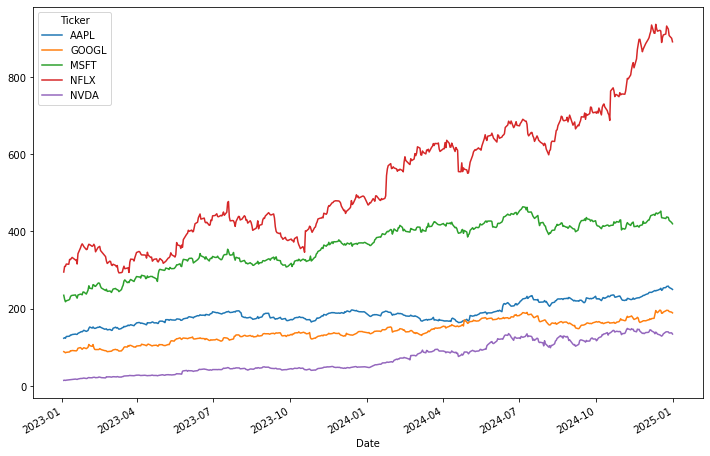

In [17]:
print(stock['Close'].shape)
stock['Close'].plot(figsize=(12, 8))

In [18]:
close.head()

NameError: name 'close' is not defined